In [1685]:
##Imports

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

#Feature Selection and Parameter Tuning
import sklearn.cross_validation as cv
import sklearn.feature_selection as fs
import sklearn.grid_search as gs

In [1686]:
# Transform csv files to corresponding pandas DataFrames
train_df = pd.read_csv('data/train.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [1687]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1688]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1689]:
Y_train = train_df['Survived']

#Combining train and test rows to help reduce repeated work in Data Analysis and Feature Engineering
combined_df = train_df.drop('Survived',axis=1).append(test_df)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [1690]:
## Incomplete Columns in Training and Test Data
print("Incomplete Data Columns: ")
print(np.sum(combined_df.loc[:,combined_df.isnull().any(axis=0)==True].isnull()))

Incomplete Data Columns: 
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [1691]:
#Description of Numerical Variables
combined_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1692]:
#Description of Categorical Variables
combined_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## Finding Deck from Cabin data

Cabin and Ticket features are not unique to passengers. My hypothesis is that by finding out passengers with same ticket or cabin, we can find out the other feature. My idea is to infer the Cabin number (Deck = First Letter) from the common Ticket number if any and from the fare/Pclass.

Steps:

1. Figure out Ticket-Cabin mappings whichever present - Just first letter is also okay
2. Figure out Fare + Pclass -> Cabin mappings -> Just first letter is also okay
3. Need to also figure out is Fare per person or per family 

In [1693]:
def get_deck(cabin):
    if pd.isnull(cabin):
        return("U")
    else:
        return(cabin[0])

In [1694]:
# Creating a Cabin Deck Column
combined_df["Deck"] = combined_df['Cabin'].map(get_deck)# = combined_df["Cabin"].str[0]

In [1695]:
combined_df.Deck.value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

We observe majority of the Deck information is Unknown!

### Filling Deck Missing Data

Few Cabins with NaN actually share the same Ticket. We can use this to fill up Deck values. It might so happen that all the passengers with same ticket might have NaN cabin. In that case, we can either:

a) randomly select from the cabin decks of same pclass and Embarked

b) retain Unknown

c) Obtaining Family Trees would be perfect (as described here: https://www.kaggle.com/c/titanic/prospector#208) but not sure if that detail is currently required. Will go back to this later.

Currently, I am retaining Unknown and will explore other options in the future.

In [1696]:
# Creating a Ticket-Deck Dictionary
ticket_deck_map = {}
for index, row in combined_df.iterrows():
    if row['Deck'] != 'U':
        ticket_deck_map[row['Ticket']] = row['Deck']

In [1697]:
#Filling missing Cabin info
for index, row in combined_df.iterrows():
    if row['Deck'] == 'U':
        if row['Ticket'] in ticket_deck_map.keys():
            combined_df.loc[index,'Deck'] = ticket_deck_map[row['Ticket']]

In [1698]:
combined_df.Deck.value_counts()

U    989
C    109
B     71
D     46
E     42
F     24
A     22
G      5
T      1
Name: Deck, dtype: int64

Unfortunately, Unknown is still large in number with only 25 missing values filled. Let's explore the relationship between Deck and Survival rate.

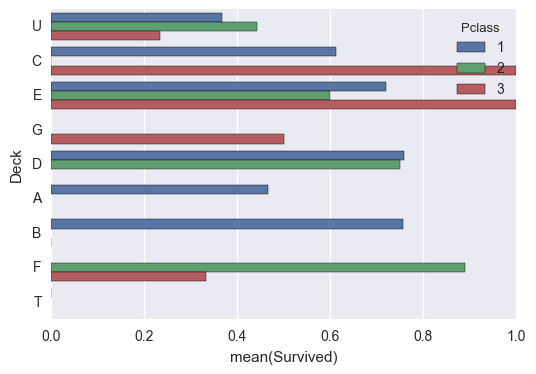

In [1699]:
train_df = pd.concat([combined_df.iloc[:891,:],Y_train],axis=1)
sns.barplot(hue='Pclass', x="Survived", y="Deck", data = train_df, ci=True)

#### Observations  

1. Independent of the Pclass, the passengers with "Unknown" Deck have the Lowest Survival rate.

2. All passengers in Cabin E Pclass = 3 survived!

3. Cabin T is not present in training data set

4. Cabin A,B,C had only passengers from Pclass=1 in training data set.

5. Deck should definitely be a feature for the prediction.

## Ticket Data

In [1700]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip() , ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [1701]:
combined_df['Ticket'] = combined_df['Ticket'].map(cleanTicket)

In [1702]:
np.unique(combined_df.Ticket)

array(['A', 'A4', 'A5', 'AQ3', 'AQ4', 'AS', 'C', 'CA', 'CASOTON', 'FC',
       'FCC', 'Fa', 'LINE', 'LP', 'PC', 'PP', 'PPP', 'SC', 'SCA3', 'SCA4',
       'SCAH', 'SCOW', 'SCPARIS', 'SCParis', 'SOC', 'SOP', 'SOPP',
       'SOTONO2', 'SOTONOQ', 'SP', 'STONO', 'STONO2', 'STONOQ', 'SWPP',
       'WC', 'WEP', 'XXX'], dtype=object)

## Fare Per Person 

There are passengers with same ticket numbers and their fare listed is actually the sum total and not individual. When we divide the fare of such passengers by the shared number, the fare of Pclass = 1 gets closer to the Pclass=2 and 3 passengers. It will be interesting to analyze the spread of the fares per person.

In [1703]:
combined_df['FarePerPerson'] = train_df['Fare']

# Indicator for a Ticket held by Multi-Passengers 0 = No, 1 - Yes

for index, row in combined_df.iterrows():
        count = len(Counter(combined_df.loc[combined_df.Ticket==row['Ticket'],'Ticket']))
        if count > 1:
            combined_df.loc[index,'FarePerPerson'] = float(row['Fare']/(count))

In [1704]:
combined_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FarePerPerson
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5,7.2500,NaN,S,U,7.2500
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC,71.2833,C85,C,C,71.2833
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO2,7.9250,NaN,S,U,7.9250
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,XXX,53.1000,C123,S,C,53.1000
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,XXX,8.0500,NaN,S,U,8.0500


## Family 

In [1705]:
# Adding Family as a new Feature column in train_df. Family = Parch + SibSp
combined_df['FamilySize'] = train_df['Parch'] + train_df['SibSp'] + 1

combined_df['Singleton'] = combined_df['FamilySize'].map(lambda s : 1 if s == 1 else 0)
combined_df['SmallFamily'] = combined_df['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
combined_df['LargeFamily'] = combined_df['FamilySize'].map(lambda s : 1 if 5<=s else 0)

## Titles

Several names have titles that can provide another degree of freedom in our Analysis. Titles indicate the whether the passenger was a Civilian or Staff member in Titanic. Also, they indicate an adult vs child, honorary member vs regular citizen etc.

In [1706]:
# Adding Title feature
combined_df['Title'] = combined_df.Name.map(lambda name:name.split(',')[1].split('.')[0].strip())

# a map of more aggregated titles
Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
combined_df['Title'] = combined_df.Title.map(Title_Dictionary)

In [1707]:
np.unique(combined_df.Title)

array(['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty'], dtype=object)

## Exploratory Data Analysis

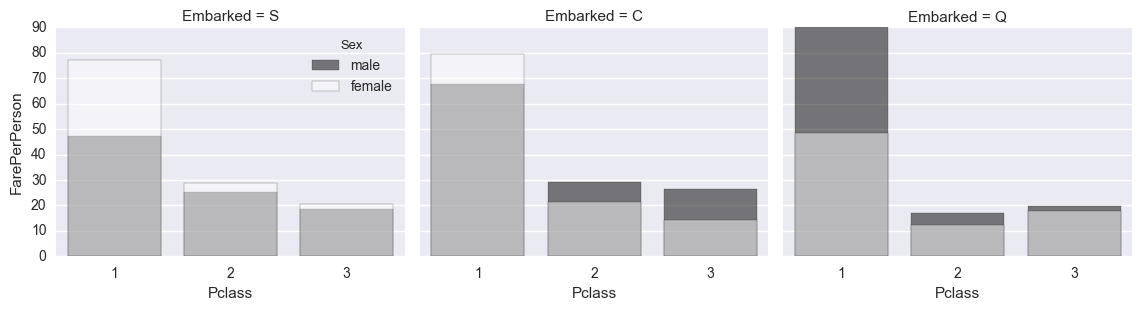

In [1708]:
grid = sns.FacetGrid(combined_df, col='Embarked', hue='Sex',palette={'male': 'k', 'female': 'w'},size=3.2, aspect=1.2, legend_out=False)
grid.map(sns.barplot, 'Pclass', 'FarePerPerson', alpha=0.5, ci=False)
grid.add_legend()

#### Observations

1. Fare per person is higher for female passengers independent of Pclass for Port 'S' with most passengers

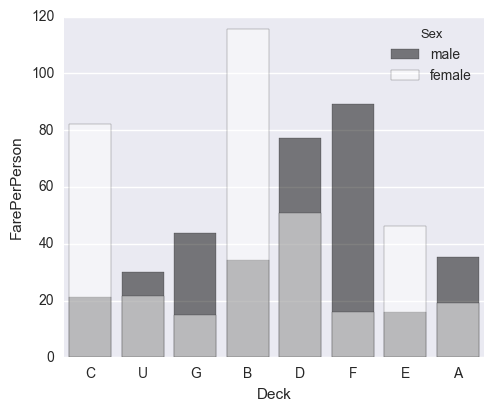

In [1709]:
grid = sns.FacetGrid(combined_df, hue='Sex',palette={'male': 'k', 'female': 'w'},size=4.2, aspect=1.2, legend_out=False)
grid.map(sns.barplot, 'Deck', 'FarePerPerson', alpha=0.5, ci=False)
grid.add_legend()

#### Observations

1. Depending on the Deck, the fare difference is significantly higher either for Female or Male passengers
   
   a) Female > Male in Decks C, B, E
   
   b) Male > Female in Decks G, F, U, A and D
 
2. This could be because of the age distribution of passengers in each Deck and accordingly the FarePerPerson changing with the age.
    

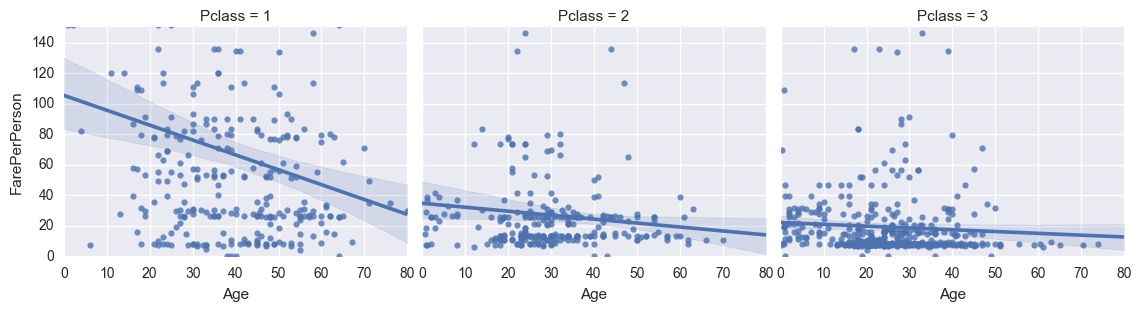

In [1710]:
grid = sns.FacetGrid(combined_df, col='Pclass', size=3.2, aspect=1.2, legend_out=False)
grid.map(sns.regplot, 'Age', 'FarePerPerson')
grid.set(ylim=((0,150)))
grid.set(xlim=((0,80)))
grid.add_legend()

#ax1 = sns.regplot(train_df['Age'],train_df['FarePerPerson'])
#ax1 = sns.regplot(train_df.loc[train_df.Pclass==3,'Age'],train_df.loc[train_df.Pclass==3,'FarePerPerson'])
#ax1.set_ylim([0,50])
#ax1.set_xlim([40,90])

#### Observations:

1. Fare Per Person is among the lowest for ages > 60 for each of the Pclass.

2. Fare per person for ages < 10 is not in the lowest for any of the Pclasses. This is because most children are accompanied by parents or siblings. So, the Fare Per Person obtained on averaging the fare is not the true Fare per child. 

3. As shown below, there is a single Child with Parch=0 on the ship. It is difficult to estimate if there is a fixed Fare for children considering the Fare has been observed to vary per Pclass, age, gender and Deck.

In [1711]:
combined_df.loc[(combined_df.Age < 10) & (combined_df.FamilySize==1),:].shape

(17, 18)

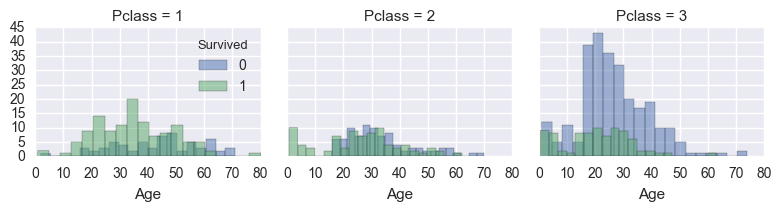

In [1712]:
#fig = plt.figure(figsize=(15,15))
#sns.linearmodels.corrplot(train_df)
#plt.title("Correlation Matrix Visualization",fontsize=18)

grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived', size=2.2, aspect=1.2, legend_out=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

#### Observations:

1) Infants in Pclass = 2 have all survived.

2) Pclass = 3 has most passengers but most did not survive.

3) Pclass = 1 has highest survival rate

4) Both Age and Pclass should be included in Model training.


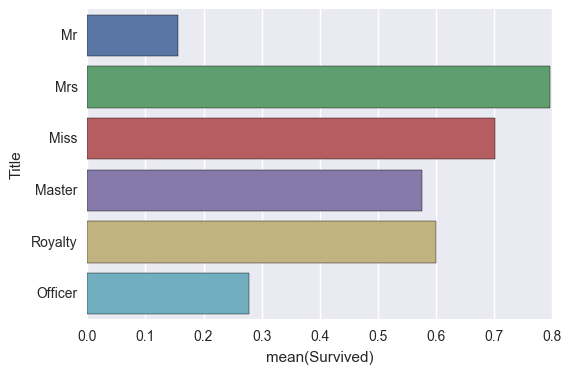

In [1713]:
train_df = pd.concat([combined_df.iloc[:891,:],Y_train],axis=1)
sns.barplot(x="Survived", y="Title", data = train_df, ci=False)

### Observations:

1) Female Titles including Mrs., followed by Ms. have the highest survival >= 0.7

2) On the other hand, titles including Mr. and Officer had < 30% survival

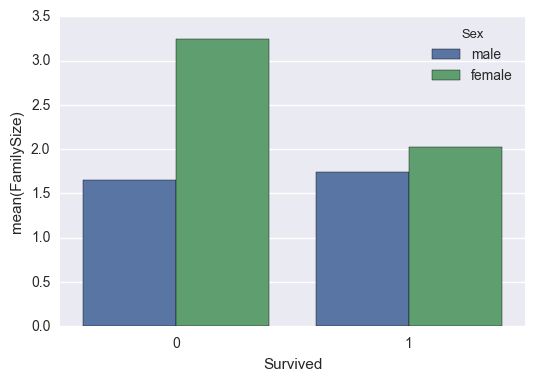

In [1714]:
sns.barplot(x="Survived", y="FamilySize", hue="Sex",data = train_df, ci=False)

#### Observations

Those who survived, interestingly had a lower average for Family. This might be because the non-survivors died while trying to save their relatives.

## Converting Categorical features to numerical features

In [1715]:
#Sex to Gender
combined_df['Gender'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

## Completing a numerical continuous feature - Age

In [1716]:
# Using correlated features: Pclass, Gender
age_estimate = np.zeros([2,3]) # 2- Gender, 3 - Pclass

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = combined_df[(combined_df['Gender'] == i) & \
                              (combined_df['Pclass'] == j+1)]['Age'].dropna()
        
        age_est = guess_df.median()

        # Convert random age float to nearest .5 age
        age_estimate[i,j] = int(age_est/0.5 + 0.5 ) * 0.5
        
age_estimate

array([[ 40.,  29.,  25.],
       [ 36.,  28.,  22.]])

In [1717]:
combined_df['AgeFill'] = combined_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        combined_df.loc[ (combined_df.Age.isnull()) & (combined_df.Gender == i) & (combined_df.Pclass == j+1),\
                'AgeFill'] = age_estimate[i,j]

#train_df[train_df['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(10)

## Completing a categorical feature - Embarked

In [1718]:
# With only 2 values missing in Training Data set and 0 in Test Datra Set
# We simply place the most popular Embarkment port for missing data

popular_embarkment = combined_df.Embarked.dropna().mode()[0]
popular_embarkment

'S'

In [1719]:
combined_df['EmbarkedFill'] = combined_df['Embarked']
combined_df.loc[combined_df['Embarked'].isnull(),'EmbarkedFill'] = popular_embarkment

## Converting categorical variables to numerical variables

In [1720]:
# Convert Embarked, Deck and Titles features using Pandas get_dummies()

#Decks
Deck_df = pd.get_dummies(combined_df['Deck'],prefix='Deck')
combined_df = pd.concat([combined_df,Deck_df],axis=1)

#Embarked
Port_df = pd.get_dummies(combined_df['EmbarkedFill'],prefix='Port')
combined_df = pd.concat([combined_df,Port_df],axis=1)

#Title
titles_df = pd.get_dummies(combined_df['Title'],prefix='Title')
combined_df = pd.concat([combined_df,titles_df],axis=1)

#Pclass
Pclass_df = pd.get_dummies(combined_df['Pclass'],prefix='Pclass')
combined_df = pd.concat([combined_df,Pclass_df],axis=1)

#Ticket
Ticket_df = pd.get_dummies(combined_df['Ticket'],prefix='Ticket')
combined_df = pd.concat([combined_df,Ticket_df],axis=1)

In [1721]:
## Use this for without dummies

#train_df.columns.values
#Ports = list(enumerate(np.unique(pd.concat([train_df['EmbarkedFill'],test_df['EmbarkedFill']],axis=0))))
#Ports_dict = { name : i for i, name in Ports }      

#train_df['Port'] = train_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)
#test_df['Port'] = test_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)
#train_df[['EmbarkedFill', 'Port']].head(10)

In [1722]:
# Completing one missing value of Fare feature in Test data set
combined_df['FarePerPerson'].fillna(combined_df['FarePerPerson'].dropna().median(), inplace=True)
combined_df['Fare'].fillna(combined_df['Fare'].dropna().median(), inplace=True)

In [1723]:
## Dropping Extraneous Columns
combined_df = combined_df.drop(['Cabin','Deck','Title','Embarked','EmbarkedFill','Pclass','Age'],axis=1)
combined_df = combined_df.drop(['Ticket','Name','Sex'], axis=1)
#'Fare','PassengerId','SibSp','Parch','SmallFamily'

In [1724]:
np.sum(X_test.loc[:,X_test.isnull().any(axis=0)==True].isnull())

Series([], dtype: float64)

In [1725]:
combined_df.columns.values

array(['FarePerPerson', 'FamilySize', 'Singleton', 'LargeFamily', 'Gender',
       'AgeFill', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Port_C', 'Port_Q',
       'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3',
       'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA',
       'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa',
       'Ticket_LINE', 'Ticket_LP', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP',
       'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH',
       'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC',
       'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ',
       'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ',
       'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticket_XXX'], dtype=object)

## Feature Scaling

In [1726]:
def scaling(x):
    if x.max !=0: 
        return(x/x.max())
    else: 
        return(0)

In [1728]:
features = list(combined_df.columns)
#features.remove('PassengerId')
combined_df[features] = combined_df[features].apply(lambda x: scaling(x), axis=0)

## Prediction Modeling

In [1729]:
X_train = combined_df.iloc[:891,:] #891 is the no. of training rows
X_test  = combined_df.iloc[891:,:]

#X_train = X_train[['Pclass','Gender','AgeFill','DeckBand','TitleBand']]
#X_test = X_test[['Pclass','Gender','AgeFill','DeckBand','TitleBand']]

X_train.shape, Y_train.shape, X_test.shape

((891, 64), (891,), (418, 64))

In [1730]:
# Model evaluation function
def compute_score(clf, X, y,scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5,scoring=scoring)
    return np.mean(xval)

In [1731]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=250)
clf = clf.fit(X_train, Y_train)

In [1732]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_

In [1733]:
features.sort_values(by='importance',ascending=False)

,feature,importance
5,AgeFill,0.195440
0,FarePerPerson,0.160829
20,Title_Mr,0.129816
4,Gender,0.106127
26,Pclass_3,0.041032
1,FamilySize,0.037842
19,Title_Miss,0.035624
21,Title_Mrs,0.033406
14,Deck_U,0.033172
3,LargeFamily,0.025683


### Feature Selection

In [1734]:
model = SelectFromModel(clf, prefit=True)
X_train_filt = model.transform(X_train)
X_train_filt.shape

(891, 11)

In [1735]:
X_test_filt = model.transform(X_test)
X_test_filt.shape

(418, 11)

In [1736]:
feat_bool = model.get_support()
print("Filtered Features: ", X_train.columns.values[feat_bool])

Filtered Features:  ['FarePerPerson' 'FamilySize' 'LargeFamily' 'Gender' 'AgeFill' 'Deck_U'
 'Title_Miss' 'Title_Mr' 'Title_Mrs' 'Pclass_1' 'Pclass_3']


Down to 15 features!

## Random Forest

## GridSearch

In [1737]:
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(Y_train, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train_filt, Y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

#grid_para_forest = [{"n_estimators": [10, 20, 30, 40,50], "criterion": ["gini", "entropy"], \
#                    "min_samples_leaf": np.arange(1, 15), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]

Best score: 0.835016835016835
Best parameters: {'max_depth': 8, 'criterion': 'gini', 'n_estimators': 210}


In [1741]:
Y_pred = grid_search.predict(X_test_filt)

### Random Forest Best Params Analysis

In [1739]:
grid_search.best_score_

0.835016835016835

In [1740]:
grid_search.score(X_train_filt,Y_train)

0.91133557800224463

In [1637]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 210}

In [1572]:
randomForest_best = grid_search.best_estimator_
randomForest_best.fit(X_train_filt,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [1638]:
feature_importance = zip(X_train.columns.values[feat_bool], randomForest_best.feature_importances_)
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_sort = sorted(feature_importance, key=lambda tup: tup[1],reverse=True)
feature_sort
#top_feat = [i for (i, j) in feature_sort[0:10]]

[('Deck_U', 0.24121693924583298),
 ('Pclass_1', 0.22846603850953925),
 ('SmallFamily', 0.070987238615563608),
 ('Pclass_3', 0.065565353288901188),
 ('Title_Mr', 0.060256949343119946),
 ('Title_Mrs', 0.058352092444716008),
 ('Title_Miss', 0.039674947551795042),
 ('LargeFamily', 0.036532354655931187),
 ('AgeFill', 0.029975137176015042),
 ('Gender', 0.023408884611385461),
 ('PassengerId', 0.022605118432168007),
 ('FarePerPerson', 0.014506314706084416),
 ('FamilySize', 0.010304345181279565)]

## KAGGLE Submission File

In [1742]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('submission_RF_combined_last.csv', index=False)